In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# 데이터 불러오기
data = pd.read_csv('C:/Users/82106/Desktop/모음/데이터 분석 프로젝트 2/데이콘 빅데이터 분석/data/data/한국전력거래소_시간별 신재생에너지 거래량_20220331.csv',encoding='cp949')

### 거래일을 datetime로 변환

In [2]:
# '거래일' 열을 datetime 형식으로 변환
data['거래일'] = pd.to_datetime(data['거래일'])

# '거래일' 열을 float 형식으로 변환 (시간 차이를 일 단위로 변환)
reference_date = data['거래일'].min()
data['거래일'] = (data['거래일'] - reference_date).dt.total_seconds() / (24 * 3600)

### 데이터 분할

In [3]:
# 데이터셋 분할 (학습 데이터와 테스트 데이터)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

### 모델 입력 형식으로 변환

- **create_sequences 함수**:
  - 시계열 데이터를 모델 학습 형식으로 전처리하는 역할
  - `seq_length` (여기서는 `num_unrollings`로 설정된 값)에 따라 시퀀스를 **입력 (X)** 와 **타깃 (y)** 으로 분리하는 기능
  
  - 예시: `seq_length`가 10일 때, 처음 10개의 데이터 포인트를 입력 (X)으로, 그 다음 데이터 포인트를 타깃 (y)으로 설정하여 학습 데이터 셋을 구성하는 방식

In [5]:
# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i+seq_length].values
        y = data.iloc[i+seq_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

num_unrollings = 10
seq_length = num_unrollings
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(71855, 10, 11) (71855, 11)
(17957, 10, 11) (17957, 11)


### Batch 생성

- **BatchGenerator 클래스**:
  - 시계열 데이터를 **배치 단위**로 쪼개어 모델에 입력할 수 있는 형태로 변환하는 기능 제공
  - **초기화** 시 `batch_size`와 `num_unrollings` 값을 받아, 이를 기반으로 데이터를 순차적으로 배치로 구성
  - 각 **배치(batch)**는 지정된 `batch_size`만큼의 데이터 샘플과 `num_unrollings` 길이의 시퀀스를 포함

- **_next_batch 메서드**:
  - 각 배치를 생성하여 반환하는 메서드
  - `batch_size` 크기만큼의 샘플을 생성하며, 각 샘플은 `num_unrollings` 길이의 시퀀스를 가짐
  - 데이터 끝에 도달하면 **순환 방식**으로 데이터를 이어서 사용하도록 설정

- **next 메서드**:
  - 여러 배치를 **순차적으로 생성하여 반환**
  - `last_batch`를 업데이트하여 **다음 배치를 이어서 생성**


#####  시계열 데이터를 모델 학습에 적합하게 배치로 나누어 제공

In [7]:
class BatchGenerator(object):
    def __init__(self, data, batch_size, num_unrollings):
        self.data = data
        self.batch_size = batch_size
        self.num_unrollings = num_unrollings
        self.data_len = len(data)
        segment = self.data_len // batch_size
        self.cursor = [offset * segment for offset in range(batch_size)]
        self.last_batch = self._next_batch()

    def _next_batch(self):
        batch = np.zeros((self.batch_size, self.num_unrollings, self.data.shape[1]))
        for b in range(self.batch_size):
            for u in range(self.num_unrollings):
                batch[b, u] = self.data.iloc[self.cursor[b]]
                self.cursor[b] = (self.cursor[b] + 1) % self.data_len
        return batch
    
    def next(self):
        batches = [self.last_batch]
        for step in range(self.num_unrollings):
            batches.append(self._next_batch())
        self.last_batch = batches[-1]
        return batches

# BatchGenerator 사용 예제
batch_size = 32
num_unrollings = 10

# BatchGenerator 인스턴스 생성
train_generator = BatchGenerator(train_data, batch_size, num_unrollings)

# 배치 생성 예제
example_batches = train_generator.next()
for i, batch in enumerate(example_batches):
    print(f"Batch {i} shape: {batch.shape}")

Batch 0 shape: (32, 10, 11)
Batch 1 shape: (32, 10, 11)
Batch 2 shape: (32, 10, 11)
Batch 3 shape: (32, 10, 11)
Batch 4 shape: (32, 10, 11)
Batch 5 shape: (32, 10, 11)
Batch 6 shape: (32, 10, 11)
Batch 7 shape: (32, 10, 11)
Batch 8 shape: (32, 10, 11)
Batch 9 shape: (32, 10, 11)
Batch 10 shape: (32, 10, 11)


### 전체 신재생 에너지 예측을 위해 열 제거

In [8]:
# 필요하지 않은 열 제거 (예: '거래일', '거래시간' 제외)
features = ['거래일', '거래시간', '연료전지', '석탄가스화복합화력(IGCC)', '태양광', '풍력', '수력', '해양에너지', '바이오에너지', '폐기물에너지', '신재생 합계']
data = data[features]

### 하이퍼파라미터 설정

In [9]:
# 임베딩 크기(Embedding Size) 정의
embedding_size = 128  # 각 특징을 고차원 공간에 매핑할 때 사용하는 벡터의 크기

# LSTM 노드 수 정의
num_nodes = 64  # 각 LSTM 레이어에서 사용할 노드(유닛)의 수

# Dropout 확률 정의
keep_prob_train = 0.5  # 학습 시 50%의 노드를 비활성화하여 과적합 방지
keep_prob_sample = 1.0  # 검증 시 dropout을 사용하지 않음

# 기타 하이퍼파라미터
batch_size = 32  # 한 번에 모델에 입력으로 들어가는 데이터의 샘플 수
num_unrollings = 10  # LSTM이 한 번에 처리할 시퀀스의 길이

num_features = len(features)

### TensorFlow 모델 정의와 모델 컴파일

- **입력 레이어**:
  - 입력 형태는 `(None, 10, 11)`으로, **배치 크기와 관계없이** 시퀀스 길이 10과 특징 개수 11을 받음

- **RenewableEnergyModel 레이어**:
  - 재생 에너지 데이터를 예측하는 **사용자 정의 모델 레이어**
  - 내부에는 **임베딩(Dense) 레이어**와 **두 개의 LSTM 레이어**가 포함되어 있으며, 마지막에 **Dense 레이어**로 출력 값을 예측함

- **총 파라미터 수**:
  - 총 **84,683개**의 파라미터로 구성, 모두 **훈련 가능한 파라미터**

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# TensorFlow 모델 정의
class RenewableEnergyModel(tf.keras.Model):
    def __init__(self, num_nodes, embedding_size, num_features, dropout_rate):
        super(RenewableEnergyModel, self).__init__()
        self.embedding = Dense(embedding_size, activation='relu')
        self.lstm1 = LSTM(num_nodes, return_sequences=True)
        self.lstm2 = LSTM(num_nodes)
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(num_features)
    
    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        if training:
            x = self.dropout(x, training=training)
        return self.dense(x)

# 입력 형태 정의
inputs = Input(shape=(num_unrollings, num_features))
model = RenewableEnergyModel(num_nodes, embedding_size, num_features, keep_prob_train)
outputs = model(inputs)

# 모델 컴파일
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# 모델 요약 출력
model.summary()


c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'renewable_energy_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ renewable_energy_model          │ (None, 11)             │        84,683 │
│ (RenewableEnergyModel)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,683 (330.79 KB)

 Trainable params: 84,683 (330.79 KB)

 Non-trainable params: 0 (0.00 B)

### 모델 학습 및 평가

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.1)

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


Epoch 1/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 786188.8125 - val_loss: 1392815.5000
Epoch 2/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 673977.0625 - val_loss: 1260611.5000
Epoch 3/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 585262.1250 - val_loss: 1146912.8750
Epoch 4/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 509220.8750 - val_loss: 1044898.1875
Epoch 5/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 442767.2188 - val_loss: 951953.9375
Epoch 6/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 381686.0000 - val_loss: 867384.5000
Epoch 7/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 331114.9375 - val_loss: 791053.6875
Epoch 8/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 287218.3125 - val_loss: 722672.8125
Epoch 9/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 255721.2344 - val_loss: 661388.6250
Epoch 10/50
2021/2021 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 223428.8438 - val_loss: 604902.5625
Epoc

562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


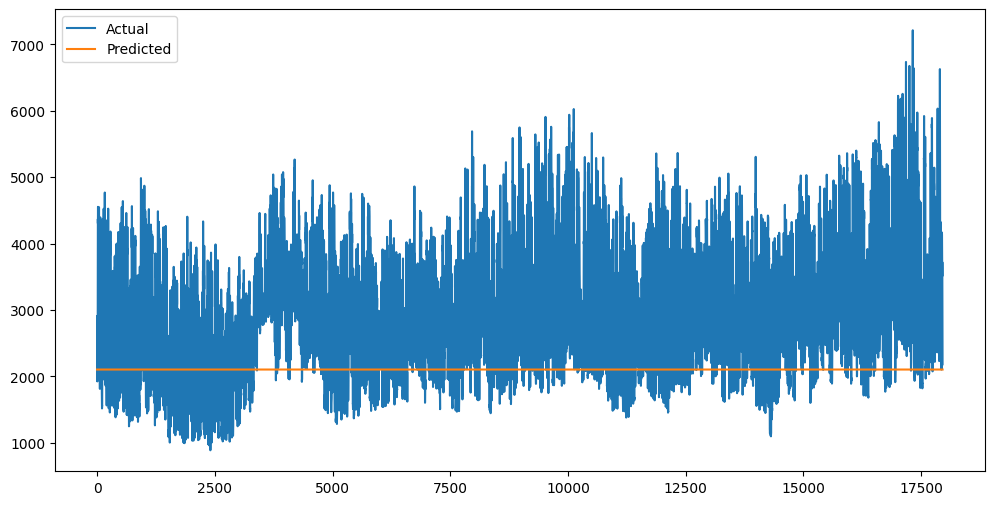

In [12]:
import matplotlib.pyplot as plt

# 예측 수행
predictions = model.predict(X_test)

# 예측 결과와 실제 값을 비교하는 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(predictions[:, -1], label='Predicted')
plt.legend()
plt.show()


### 예측이 일직선으로 나오기때문에 모델 구조를 변경

In [13]:
embedding_size = 128
num_nodes = 128  # 노드 수를 증가시켜 모델 복잡도 향상
batch_size = 32
num_unrollings = 10
dropout_rate = 0.3  # 과적합 방지를 위해 dropout 비율을 조정

### 모델 구조 재정의

In [17]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization

# 입력 특징 수 정의 (데이터셋에 맞춰야 함)
num_features = len(features)  # feature의 수를 정확히 지정

# 모델 정의
class RenewableEnergyModel(tf.keras.Model):
    def __init__(self, num_nodes, embedding_size, num_features, dropout_rate):
        super(RenewableEnergyModel, self).__init__()
        # 입력 임베딩 레이어
        self.embedding = Dense(embedding_size, activation='relu')
        # 첫 번째 LSTM 레이어
        self.lstm1 = LSTM(num_nodes, return_sequences=True)
        # 배치 정규화 레이어
        self.batch_norm1 = BatchNormalization()
        # 두 번째 LSTM 레이어
        self.lstm2 = LSTM(num_nodes, return_sequences=True)
        # 배치 정규화 레이어
        self.batch_norm2 = BatchNormalization()
        # 세 번째 LSTM 레이어
        self.lstm3 = LSTM(num_nodes)
        # Dropout 레이어
        self.dropout = Dropout(dropout_rate)
        # 출력 레이어
        self.dense = Dense(num_features)
    
    def call(self, inputs, training=False):
        # 입력 임베딩
        x = self.embedding(inputs)
        # 첫 번째 LSTM 처리 및 배치 정규화
        x = self.lstm1(x)
        x = self.batch_norm1(x)
        # 두 번째 LSTM 처리 및 배치 정규화
        x = self.lstm2(x)
        x = self.batch_norm2(x)
        # 세 번째 LSTM 처리
        x = self.lstm3(x)
        # Dropout 적용 (학습 중에만 활성화)
        if training:
            x = self.dropout(x, training=training)
        # 최종 출력
        return self.dense(x)

# 모델 인스턴스 생성
inputs = Input(shape=(num_unrollings, num_features))
model = RenewableEnergyModel(num_nodes, embedding_size, num_features, dropout_rate)
outputs = model(inputs)

c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'renewable_energy_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### 모델 컴파일
- **손실 함수**:
  - 예측값과 실제값 간 **오차를 측정**하여 학습 방향을 결정

- **최적화 알고리즘**:
  - 손실 함수 **최소화**를 위해 가중치를 업데이트하는 방법

- **평가지표**:
  - 모델 성능을 **평가**하기 위한 지표 설정


In [18]:
# 모델 컴파일
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 모델 요약 출력
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ renewable_energy_model_2        │ (None, 11)             │       398,731 │
│ (RenewableEnergyModel)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,731 (1.52 MB)

 Trainable params: 398,219 (1.52 MB)

 Non-trainable params: 512 (2.00 KB)

### 기존 모델과 비교 개선점

- **파라미터 수 증가**:
  - 새로운 모델은 기존 모델보다 약 **4.7배 많은 파라미터**를 가지며, 더 복잡한 패턴을 학습할 수 있는 **용량이 증가**

- **레이어 구조의 복잡성 증가**:
  - 기존 모델에 비해 **더 깊은 LSTM 레이어**, **배치 정규화**, **Dropout 레이어**가 추가되어 복잡한 시계열 패턴을 학습하고 **과적합을 방지**

- **학습 및 일반화 성능 개선 가능성**:
  - 더 깊은 구조로 인해 **복잡한 시계열 데이터를 잘 학습**할 수 있으며, **직선 예측 문제**를 해결할 가능성 높음

- **연산 비용 증가**:
  - **파라미터 수와 레이어가 늘어나면서 연산 비용이 증가**하여 학습 속도가 느려지고 메모리 소모가 커질 수 있음

### 모델 학습

In [21]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
)

Epoch 1/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 659003.8750 - val_loss: 1375435.2500
Epoch 2/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 498403.2812 - val_loss: 1199278.7500
Epoch 3/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 384105.5000 - val_loss: 1051462.5000
Epoch 4/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 293021.3438 - val_loss: 851766.5000
Epoch 5/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 226004.6562 - val_loss: 675977.2500
Epoch 6/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 178209.2969 - val_loss: 585285.8750
Epoch 7/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 146544.8125 - val_loss: 676807.8750
Epoch 8/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 127275.0859 - val_loss: 636957.3125
Epoch 9/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 113013.0156 - val_loss: 608678.6250
Epoch 10/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 106451.4609 - val_loss: 589974.0

In [24]:
# 예측 수행
predictions = model.predict(X_test)

562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


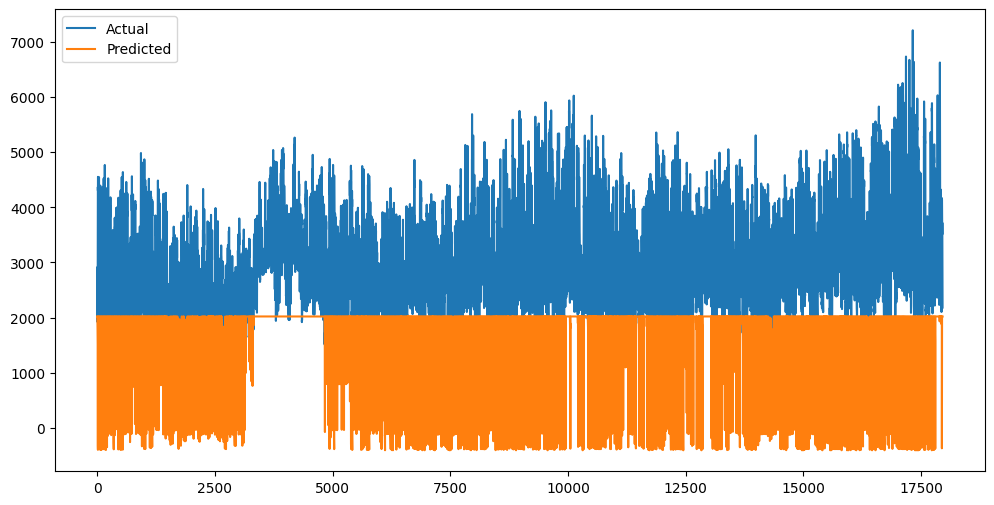

In [25]:
# 예측 결과와 실제 값을 비교하는 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual')
plt.plot(predictions[:, -1], label='Predicted')
plt.legend()
plt.show()

예측 결과가 좋지않으므로 다른 모델을 사용